This File follows the same approach as in finn-radioml. however, the tests will include customized dataset (Partial modulations only) and customized model architcture for later comparison with LogicNets approach

In [2]:
# apt-get install libhdf5-dev
! pip install --user versioned-hdf5
! pip install --user PyQt5

  Using cached versioned_hdf5-2.0.2.tar.gz (6.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      
      meson-python: error: meson executable "meson" not found
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
import numpy as np
import pickle
import os
import h5py
import matplotlib.pyplot as plt
from scipy.stats import norm

val_dir = "./val_dir"
dataset_path = '/home/gehad/Downloads/dataset/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'
print(val_dir)

./val_dir


# Load dataset

In [11]:
import torch
from torch.utils.data import Dataset, SubsetRandomSampler

class Radioml_18(Dataset):
    def __init__(self, dataset_path, snr_ratio: int = 0, sequence_length: int = None, selected_modulations=None): 
        super(Radioml_18, self).__init__()
        h5py_file = h5py.File(dataset_path, 'r')
        self.data = h5py_file['X']
        self.modulations = np.argmax(h5py_file['Y'], axis=1)
        self.snr = h5py_file['Z'][:, 0]
        self.snr_ratio = snr_ratio
        self.sequence_length = sequence_length if sequence_length is not None else self.data.shape[1]

        # Define full list of modulations
        all_modulations = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
                           '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM',
                           'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']

        # Default modulations if not provided
        if not isinstance(selected_modulations, list):
            # selected_modulations = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', 'AM-SSB-WC', 
            #                         'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']
            selected_modulations = all_modulations
        # Ensure `selected_modulations` exists in the full list
        self.mod_classes = [mod for mod in all_modulations if mod in selected_modulations]

        # Get corresponding indices
        mod_indices_to_include = [all_modulations.index(mod) for mod in self.mod_classes]

        self.snr_classes = np.arange(-20., 31., 2)

        # Filter data based on selected modulations
        data_masking = np.isin(self.modulations, mod_indices_to_include)
        self.data = self.data[data_masking]
        self.modulations = self.modulations[data_masking]
        self.snr = self.snr[data_masking]

        # Remap the modulation labels to sequential values
        self.label_mapping = {original_label: new_label for new_label, original_label in enumerate(mod_indices_to_include)}
        self.modulations = np.array([self.label_mapping[mod] for mod in self.modulations])

        np.random.seed(2018)
        train_indices, validation_indices, test_indices = [], [], []

        # Iterate over the selected modulation indices
        for new_mod_label in range(len(mod_indices_to_include)):
            mod_mask = self.modulations == new_mod_label
            mod_indices = np.where(mod_mask)[0]

            for snr_idx in range(0, 26):  # All signal to noise ratios from (-20, 30) dB
                snr_mask = self.snr[mod_indices] == self.snr_classes[snr_idx]
                indices_subclass = mod_indices[snr_mask]

                if len(indices_subclass) == 0:
                    continue

                np.random.shuffle(indices_subclass)
                train_indicies_sublcass = indices_subclass[:int(0.7 * len(indices_subclass))]
                validation_indices_subclass = indices_subclass[int(0.7 * len(indices_subclass)):int(0.85 * len(indices_subclass))]
                test_indicies_subclass = indices_subclass[int(0.85 * len(indices_subclass)):]

                if snr_idx >= snr_ratio:
                    train_indices.extend(train_indicies_sublcass)
                    validation_indices.extend(validation_indices_subclass)
                    test_indices.extend(test_indicies_subclass)

        self.train_sampler = SubsetRandomSampler(train_indices)
        self.validation_sampler = SubsetRandomSampler(validation_indices)
        self.test_sampler = SubsetRandomSampler(test_indices)

        print('Filtered dataset shape:', self.data.shape)
        print("Train indices for selected SNRs:", len(train_indices))
        print("Validation indices for selected SNRs:", len(validation_indices))
        print("Test indices for selected SNRs:", len(test_indices))

        input_length = self.data.shape[1]
        print("Input length:", input_length)

    def __getitem__(self, index):
        assert self.sequence_length <= self.data.shape[1], \
            f"Sequence length {self.sequence_length} exceeds data length {self.data.shape[2]}"

        sequence = self.data[index, :self.sequence_length, :]
        label = self.modulations[index]
        return torch.tensor(sequence.transpose(), dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(self.snr[index])

    def __len__(self): 
        return self.data.shape[0]

    def get_original_label(self, new_label):
        """Get the original modulation label from the new label."""
        for orig_label, mapped_label in self.label_mapping.items():
            if mapped_label == new_label:
                return self.mod_classes[orig_label]

In [12]:
from torch.utils.data import DataLoader
radioml_18_dataset = Radioml_18(dataset_path, snr_ratio=25)
test_loader = DataLoader(radioml_18_dataset, batch_size=1024, sampler=radioml_18_dataset.test_sampler)

# print the firsh batch shape 
print(next(iter(test_loader))[0].shape)

Filtered dataset shape: (2555904, 1024, 2)
Train indices for selected SNRs: 78624
Validation indices for selected SNRs: 9840
Test indices for selected SNRs: 9840
Input length: 1024
torch.Size([1024, 2, 1024])


# quantize Data 

In [13]:
def quantize(data):
    #quantization parameters from training
    quant_min = -2.0
    quant_max = 2.0

    quant_range = quant_max - quant_min
    data_quant = (data - quant_min) / quant_range
    data_quant = np.round(data_quant * 256) - 128
    data_quant = np.clip(data_quant, -128, 127)
    data_quant = data_quant.astype(np.int8)
    return data_quant

# sample inspection 

Modulation: 8PSK, SNR: 30.0 dB, Index: 636056


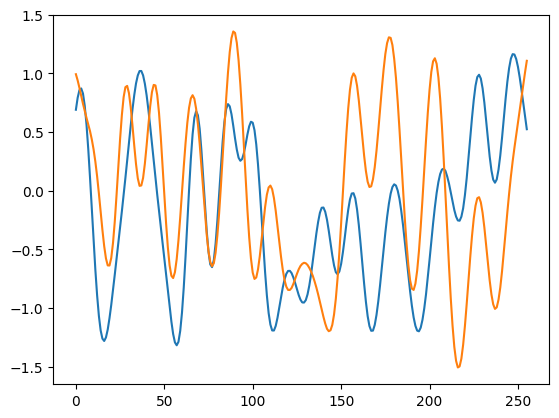

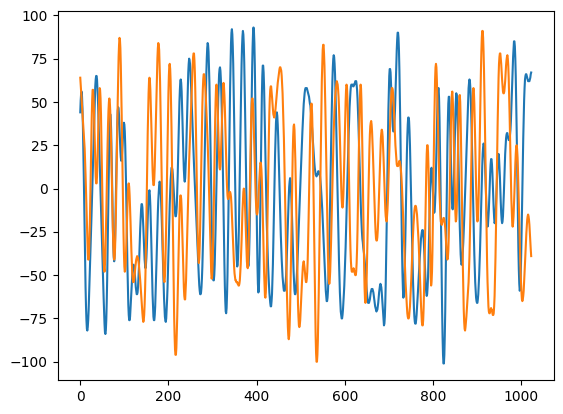

In [18]:
mod_classes = radioml_18_dataset.mod_classes

h5py_file = h5py.File(dataset_path, 'r')

X = h5py_file['X']
Y = np.argmax(h5py_file['Y'], axis=1)
Z = h5py_file['Z'][:, 0]

mod = 5 # 0 to 23
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 1176 # 0 to 4096
####
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = X[idx], Y[idx], Z[idx]
data_q = quantize(X[idx])
plt.figure()
plt.plot(data[:256])
plt.figure()
plt.plot(data_q)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (mod_classes[mod], snr, idx))

-20 dB I mean: -0.000058, median: 0.000388, std_dev: 0.707321
-20 dB I range: [-3.387527,3.339643]
-20 dB I 99%-range: [-1.822103,1.822343]
-20 dB I 95%-range: [-1.386738,1.385390]
-20 dB Q mean: -0.000417, median: -0.000073, std_dev: 0.707568
-20 dB Q range: [-3.548932,3.481035]
-20 dB Q 99%-range: [-1.822135,1.820667]
-20 dB Q 95%-range: [-1.387908,1.385950]
+30 dB I mean: 0.012220, median: 0.005067, std_dev: 1.360234
+30 dB I range: [-4.425910,4.435625]
+30 dB I 99%-range: [-3.214575,3.229899]
+30 dB I 95%-range: [-2.695230,2.713837]
+30 dB Q mean: 0.000034, median: -0.006776, std_dev: 1.351187
+30 dB Q range: [-4.338320,4.329381]
+30 dB Q 99%-range: [-3.217145,3.218709]
+30 dB Q 95%-range: [-2.693497,2.701255]


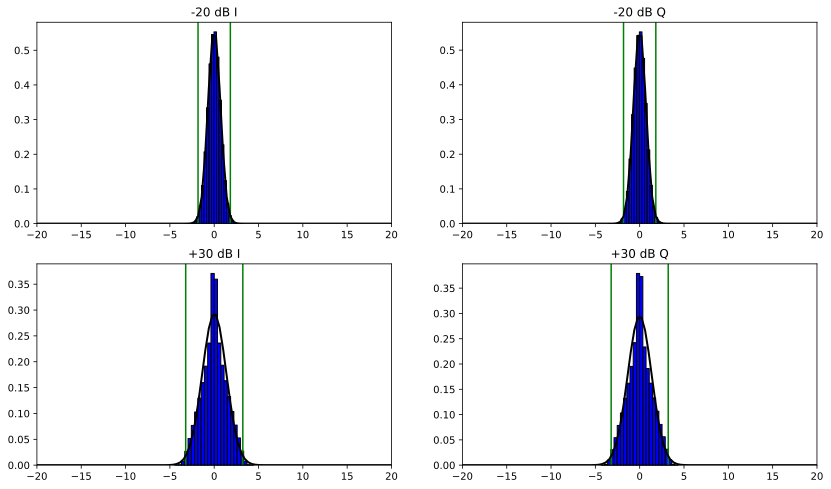

In [22]:
%config InlineBackend.figure_format = 'svg'
mods = [2]
####
data_I_low = []
data_Q_low = []
data_I_high = []
data_Q_high = []
for mod in mods:
    snr_idx = 0 # 0 to 25 = -20dB to +30dB
    idx = 26*4096*mod + 4096*snr_idx
    data_I_low = np.concatenate((data_I_low, X[idx:idx+4096,:,0]), axis=None)
    data_Q_low = np.concatenate((data_Q_low, X[idx:idx+4096,:,1]), axis=None)

    snr_idx = 25 # 0 to 25 = -20dB to +30dB
    idx = 26*4096*mod + 4096*snr_idx
    data_I_high = np.concatenate((data_I_high, X[idx:idx+4096,:,0]), axis=None)
    data_Q_high = np.concatenate((data_Q_high, X[idx:idx+4096,:,1]), axis=None)

def analyze(data, title, subplot=1):
    plt.subplot(subplot)
    plt.xlim([-20,20])
    plt.title(title)
    plt.hist(data.flatten(), bins=24, density=True, edgecolor="black", color='b')
    minimum = np.min(data)
    maximum = np.max(data)
    percentile_99_lower = np.percentile(data, 0.5)
    percentile_99_upper = np.percentile(data, 99.5)
    percentile_95_lower = np.percentile(data, 2.5)
    percentile_95_upper = np.percentile(data, 97.5)
    #plt.axvline(x=minimum, color="red")
    #plt.axvline(x=maximum, color="red")
    plt.axvline(x=percentile_99_lower, color="green")
    plt.axvline(x=percentile_99_upper, color="green")
    #plt.axvline(x=percentile_95_lower, color="green")
    #plt.axvline(x=percentile_95_upper, color="green")
    print("%s mean: %f, median: %f, std_dev: %f"%(title, np.mean(data), np.median(data), np.std(data)))
    print("%s range: [%f,%f]"%(title, minimum, maximum))
    print("%s 99%%-range: [%f,%f]"%(title, percentile_99_lower, percentile_99_upper))
    print("%s 95%%-range: [%f,%f]"%(title, percentile_95_lower, percentile_95_upper))
    
    # fit normal dist
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, dev = norm.fit(data)
    f = norm.pdf(x, mu, dev)
    plt.plot(x, f, color="black", linewidth=2)

plt.figure(figsize=(14,8))
analyze(data_I_low, "-20 dB I", 221)
analyze(data_Q_low, "-20 dB Q", 222)
analyze(data_I_high, "+30 dB I", 223)
analyze(data_Q_high, "+30 dB Q", 224)

Mean clipping at -20 dB:
0.0009721914927164713
Mean clipping at +30 dB:
0.00676192839940389
Mean clipping at +30 dB w/o SSB:
0.007376649162986062


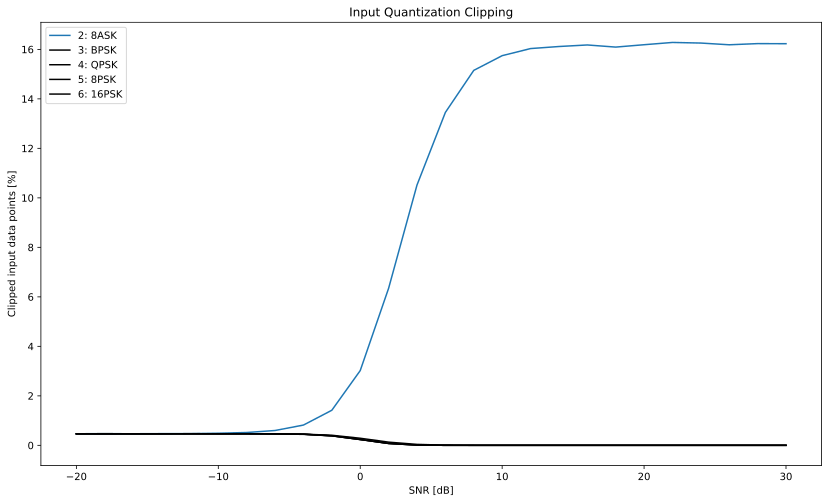

In [39]:
mods = range(2, 7)
coloring = [0, 17, 18, 1, 2]

quant_max = 2.0
quant_min = -quant_max
####
snr_idxs = range(0, 26)
clipped = np.zeros((24,len(snr_idxs)))
for mod in mods:
    for snr_idx in snr_idxs:
        idx = 26*4096*mod + 4096*snr_idx
        data = X[idx:idx+4096,:,:].flatten()
        clipped[mod][snr_idx] = np.count_nonzero((data < quant_min) | (data > quant_max))/len(data)

plt.figure(figsize=(14,8))
plt.title("Input Quantization Clipping")
plt.xlabel("SNR [dB]")
plt.ylabel("Clipped input data points [%]")
x = radioml_18_dataset.snr_classes[snr_idxs]
for mod in mods:
    if mod not in coloring:
        plt.plot(x, clipped[mod,:]*100, label=str(mod) + ": " + mod_classes[mod], color="black")
    else:
        plt.plot(x, clipped[mod,:]*100, label=str(mod) + ": " + mod_classes[mod])
plt.legend();


print("Mean clipping at -20 dB:")
print(np.mean(clipped[:,0]))
print("Mean clipping at +30 dB:")
print(np.mean(clipped[:,25]))
print("Mean clipping at +30 dB w/o SSB:")
print(np.mean(np.concatenate((clipped[0:17,25],clipped[19:24,25]))))

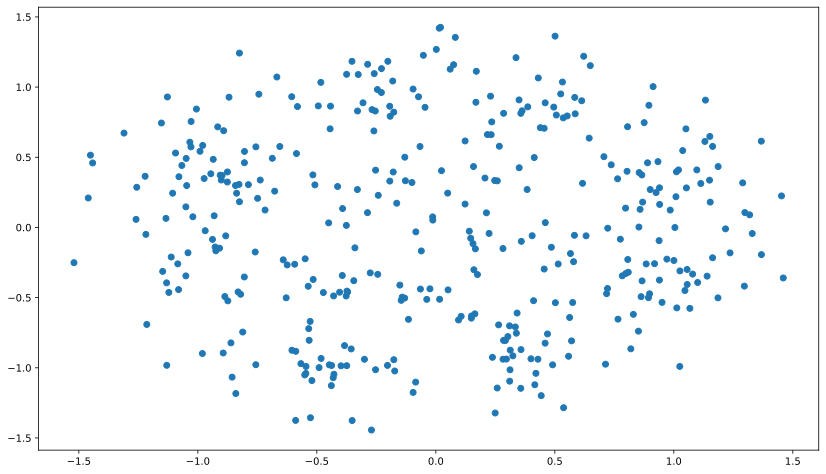

In [27]:
mod = 5
snr_idx = 25 # 0 to 25 = -20dB to +30dB
#####
idx = 26*4096*mod + 4096*snr_idx
no_samples = 3
data_I = X[idx:idx+no_samples,0::8,0]
data_Q = X[idx:idx+no_samples,0::8,1]

plt.figure(figsize=(14,8))
plt.scatter(data_I, data_Q)
